In [1]:
%matplotlib inline

In [3]:
from lifelines import KaplanMeierFitter
import pandas
import gripql
conn = gripql.Connection("http://grip.compbio.ohsu.edu")
O = conn.graph("bmeg_rc1_2")

In [6]:
q = O.query().V("Project:TCGA-BRCA").in_("InProject")

print(list(q.limit(2)))


[INFO]	2019-02-22 09:16:18,985	2 results received in 0 seconds


[<AttrDict({'gid': 'Case:6412854a-f874-469e-9d1f-8bd3ae5bd41d', 'label': 'Case', 'data': {'case_id': '6412854a-f874-469e-9d1f-8bd3ae5bd41d', 'gdc_attributes': {'demographic': {'created_datetime': None, 'demographic_id': '28997563-c9b6-5c32-903e-28e75f989979', 'ethnicity': 'not reported', 'gender': 'female', 'race': 'not reported', 'state': 'released', 'submitter_id': 'TCGA-A8-A08R_demographic', 'updated_datetime': '2018-09-06T13:49:20.245333-05:00', 'year_of_birth': 1956, 'year_of_death': None}, 'diagnoses': [{'age_at_diagnosis': 19298, 'classification_of_tumor': 'not reported', 'created_datetime': None, 'days_to_birth': -19298, 'days_to_death': None, 'days_to_last_follow_up': 30, 'days_to_last_known_disease_status': None, 'days_to_recurrence': None, 'diagnosis_id': 'f22329f5-b763-5fce-b311-69dad473af6d', 'last_known_disease_status': 'not reported', 'morphology': '8500/3', 'primary_diagnosis': 'Infiltrating duct carcinoma, NOS', 'prior_malignancy': 'not reported', 'progression_or_recur

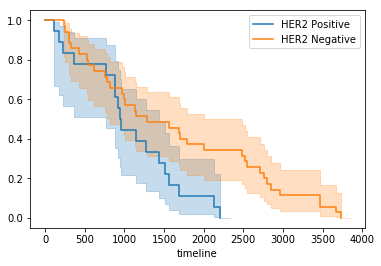